# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline

In [2]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Read in full sparkify dataset
#event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
event_data = "./mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
#df.groupBy('page').count().orderBy('count').show()



In [5]:
# Define Churn by user: This will be a binary column called "label". If user has cancelled once, this will be one for this user
df = df.withColumn("Churn", F.when(df.page == 'Cancellation Confirmation',1).otherwise(0))
df.head()

label_user = df.select("Churn", "userId").groupBy("userId").sum()
label_user = label_user.withColumnRenamed("sum(Churn)", "ChurnSum")
label_user.head()

generate_labels = F.udf(lambda x: 1 if x > 0 else 0, IntegerType())
label_user = label_user.withColumn("label", generate_labels(label_user.ChurnSum))
label_user = label_user.drop("ChurnSum")
label_user.head(20)





[Row(userId='100010', label=0),
 Row(userId='200002', label=0),
 Row(userId='125', label=1),
 Row(userId='51', label=1),
 Row(userId='124', label=0),
 Row(userId='7', label=0),
 Row(userId='54', label=1),
 Row(userId='15', label=0),
 Row(userId='155', label=0),
 Row(userId='132', label=0),
 Row(userId='154', label=0),
 Row(userId='100014', label=1),
 Row(userId='101', label=1),
 Row(userId='11', label=0),
 Row(userId='138', label=0),
 Row(userId='300017', label=0),
 Row(userId='29', label=1),
 Row(userId='69', label=0),
 Row(userId='100021', label=1),
 Row(userId='42', label=0)]

In [6]:
# Those missing data seems to contain still relevant info in the "page" section:
# Users are visiting the Help section, getting an error, down- or upgrading songs.
# In order to keep this useful information, we count those occurences by user and then compute summary statistics about positive and negative interactions
# Prepare pages by user field 

pages_by_user = df.groupBy(['userId']).pivot('page').count().fillna(0)
pages_by_user.head()
pages_by_user.printSchema()

#pages_by_user = pages_by_user.drop(*('Cancel', 'Cancellation Confirmation'))

cols_to_sum_over = [element for element in pages_by_user.columns if element != 'userId']



pages_by_user = pages_by_user.withColumn("TotalInteractions", sum(pages_by_user[col] for col in cols_to_sum_over))
pages_by_user = pages_by_user.withColumn("PositiveInteractions", F.col('Add Friend') + F.col('Add to Playlist') + F.col('NextSong') + F.col('Thumbs Up') + F.col('Upgrade'))
pages_by_user = pages_by_user.withColumn("NegativeInteractions", F.col('Submit Downgrade') + F.col('Error') + F.col('Help') + F.col('Downgrade') + F.col('Thumbs Down'))
pages_by_user = pages_by_user.withColumn("SharePositiveInteractions", F.col("PositiveInteractions") / F.col("TotalInteractions"))
pages_by_user = pages_by_user.withColumn("ShareNegativeInteractions", F.col("NegativeInteractions") / F.col("TotalInteractions"))
pages_by_user = pages_by_user.select(F.col('userId'), F.col('SharePositiveInteractions'), F.col('ShareNegativeInteractions'))
pages_by_user.head(3)


root
 |-- userId: string (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Cancel: long (nullable = true)
 |-- Cancellation Confirmation: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Login: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Register: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Registration: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)



[Row(userId='200002', SharePositiveInteractions=0.890295358649789, ShareNegativeInteractions=0.027426160337552744),
 Row(userId='100010', SharePositiveInteractions=0.800524934383202, ShareNegativeInteractions=0.01837270341207349),
 Row(userId='125', SharePositiveInteractions=0.7272727272727273, ShareNegativeInteractions=0.0)]

In [7]:
# Some descriptive statistics about churn
df.groupBy('Churn').count().orderBy('count').show()


# Descriptive Stats about Churn
#df.groupBy('Churn').mean('itemInSession').show()
# df.groupBy(['Churn', 'level']).count().show()

+-----+------+
|Churn| count|
+-----+------+
|    1|    52|
|    0|286448|
+-----+------+



## Install newest version of seaborn for plots


In [8]:
import sys
!{sys.executable} -m pip install seaborn==0.11.0

In [9]:
import pkg_resources
root_packages=['seaborn']
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print(f"{m.project_name}=={m.version}")

seaborn==0.11.0


In [32]:
import seaborn as sns
from matplotlib import pyplot as plt
print(sns.__version__)

0.11.0


In [11]:
# Prepare missing user data


df = df.dropna(how='any', subset=['artist', 'firstName'])

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [12]:
# Timestamp column - extract number of days registered
df = df.withColumn("TimeRegistered", df.ts - df.registration)
df = df.withColumn("TimeRegisteredSeconds", df.TimeRegistered / 1000)
df = df.withColumn("DaysRegistered", F.ceil(df.TimeRegisteredSeconds / (60*60*24)))

In [13]:
# Count the number of different songs a user has listend to
songs_by_user = df.select('userId', 'song').dropDuplicates().groupBy('userId').count()
songs_by_user = songs_by_user.withColumnRenamed("count", "NumberOfDifferentSongs")

In [14]:
# Compute total, mean and std of the length of songs a user has listened to 
total_length_by_user = df.select('userId', 'length').groupBy('userId').sum()
total_length_by_user = total_length_by_user.withColumnRenamed("sum(length)", "TotalLength")

avg_length_by_user = df.select('userId', 'length').groupBy('userId').mean()
avg_length_by_user = avg_length_by_user.withColumnRenamed("avg(length)", "AvgLength")

std_length_by_user = df.select('userId', 'length').groupBy('userId').agg(F.stddev('length'))
std_length_by_user = std_length_by_user.withColumnRenamed("stddev_samp(length)", "StdLength")

In [15]:
# Extract the US state of the user (occurs after the comma, as in 'Bakersfield, CA')
extract_state = F.udf(lambda x: "Missing" if x == '' else (x.split(", ")[1]), StringType())
df = df.withColumn("State", extract_state(df.location))
df.groupBy('State').count().orderBy(F.desc('count')).show()

+-----------+-----+
|      State|count|
+-----------+-----+
|         CA|38271|
|         TX|19296|
|   NY-NJ-PA|19268|
|      MA-NH|11415|
|         FL|10729|
|         NC| 8729|
|      NC-SC| 6433|
|         CO| 6198|
|         MI| 5914|
|         NJ| 5881|
|      KY-IN| 5664|
|         CT| 5545|
|PA-NJ-DE-MD| 4799|
|   IL-IN-WI| 4088|
|         NH| 4007|
|         AZ| 3956|
|      MO-IL| 3923|
|         MS| 3909|
|         VA| 3885|
|         NY| 3704|
+-----------+-----+
only showing top 20 rows



In [16]:
# Only keep relevant columns for analysis and consoliate dataframe by user
# Keep only the latest level data for a user - the last access by a user is with high likelihood also when he churned
df_by_user = df.select(['userId', 'userAgent', 'State', 'level', 'itemInSession', 'gender', 'DaysRegistered']).orderBy(F.desc('ts')).dropDuplicates(['userId'])
df_by_user.head(5)



[Row(userId='100010', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', State='CT', level='free', itemInSession=33, gender='F', DaysRegistered=56),
 Row(userId='200002', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D167 Safari/9537.53"', State='IL-IN-WI', level='paid', itemInSession=142, gender='M', DaysRegistered=71),
 Row(userId='125', userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', State='TX', level='free', itemInSession=7, gender='M', DaysRegistered=72),
 Row(userId='124', userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', State='NJ', level='paid', itemInSession=125, gender='F', DaysRegistered=131),
 Row(userId='51', userAgent='"

In [17]:
# Define string indexer to convert level, state and gender into numeric columns

level_indexer = StringIndexer(inputCol="level", outputCol="NumLevel")
state_indexer = StringIndexer(inputCol="State", outputCol="NumState")
gender_indexer = StringIndexer(inputCol="gender", outputCol="NumGender")
agent_indexer = StringIndexer(inputCol="userAgent", outputCol="NumAgent")

df_by_user = level_indexer.fit(df_by_user).transform(df_by_user)
df_by_user = state_indexer.fit(df_by_user).transform(df_by_user)
df_by_user = gender_indexer.fit(df_by_user).transform(df_by_user)
df_by_user = agent_indexer.fit(df_by_user).transform(df_by_user)

In [18]:
# Merge dataframes into one dataframe in which one row corresponds to a user with features and label ("churn")

df_modelling = df_by_user.join(songs_by_user, ['userId'], 'left')

for dataframe in [total_length_by_user, avg_length_by_user, std_length_by_user, pages_by_user, label_user]: 
    
    df_modelling = df_modelling.join(dataframe, ['userId'], 'left')

df_modelling.head(5)

[Row(userId='100010', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', State='CT', level='free', itemInSession=33, gender='F', DaysRegistered=56, NumLevel=1.0, NumState=5.0, NumGender=1.0, NumAgent=8.0, NumberOfDifferentSongs=269, TotalLength=66940.89735000003, AvgLength=243.421444909091, StdLength=79.5156544698794, SharePositiveInteractions=0.800524934383202, ShareNegativeInteractions=0.01837270341207349, label=0),
 Row(userId='200002', userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D167 Safari/9537.53"', State='IL-IN-WI', level='paid', itemInSession=142, gender='M', DaysRegistered=71, NumLevel=0.0, NumState=7.0, NumGender=0.0, NumAgent=14.0, NumberOfDifferentSongs=378, TotalLength=94008.87593999993, AvgLength=242.91699209302305, StdLength=75.447490312729, SharePositiveInteractions=0.890295358649789, Sh

      SharePositiveInteractions           ShareNegativeInteractions          
                           mean       std                      mean       std
label                                                                        
0                      0.889620  0.048152                  0.020061  0.008957
1                      0.851726  0.074018                  0.024420  0.010513


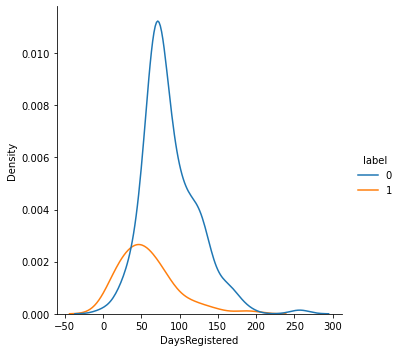

In [36]:
visualization = df_modelling.toPandas()

print(visualization.groupby("label")["SharePositiveInteractions", "ShareNegativeInteractions"].agg(['mean', 'std']))

sns.displot(visualization, x="DaysRegistered", hue="label", kind="kde")
plt.savefig("DensityDaysRegistered.png")

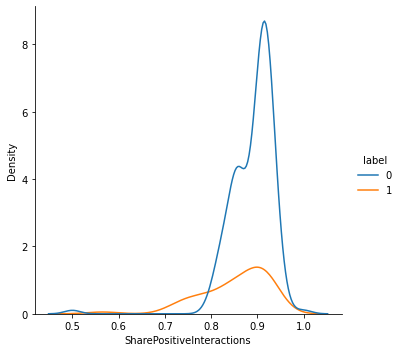

In [33]:
sns.displot(visualization, x="SharePositiveInteractions", hue="label", kind="kde")
plt.savefig("DensityPositiveInteractions.png")

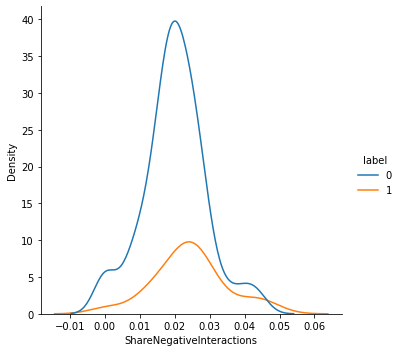

In [35]:
sns.displot(visualization, x="ShareNegativeInteractions", hue="label", kind="kde")
plt.savefig("DensityNegativeInteractions.png")

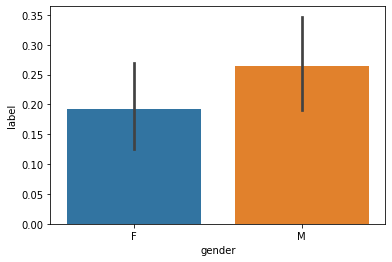

In [38]:
sns.barplot(data=visualization, x="gender", y="label")
plt.savefig("BarPlotGender.png")

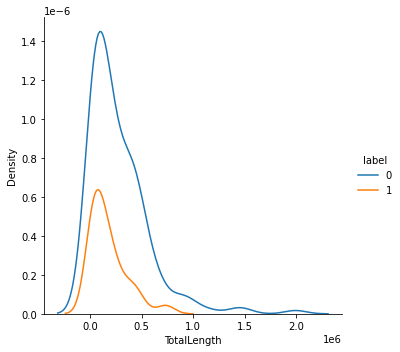

In [37]:
sns.displot(visualization, x="TotalLength", hue="label", kind="kde")


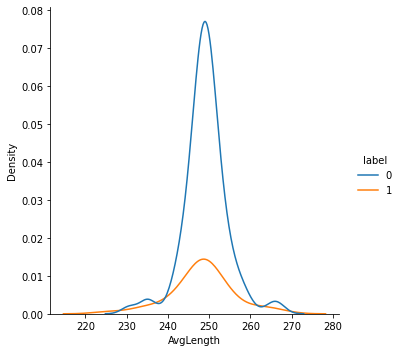

In [24]:
sns.displot(visualization, x="AvgLength", hue="label", kind="kde")

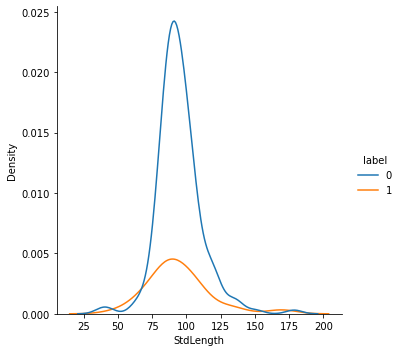

In [25]:
sns.displot(visualization, x="StdLength", hue="label", kind="kde")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [26]:
## Modelling

# Split data into train and test 

train, test = df_modelling.randomSplit([0.9, 0.1], seed=42)
train.head()
train.columns

['userId',
 'userAgent',
 'State',
 'level',
 'itemInSession',
 'gender',
 'DaysRegistered',
 'NumLevel',
 'NumState',
 'NumGender',
 'NumAgent',
 'NumberOfDifferentSongs',
 'TotalLength',
 'AvgLength',
 'StdLength',
 'SharePositiveInteractions',
 'ShareNegativeInteractions',
 'label']

In [27]:
# Define class for F1Binary Evaluator (taken from https://stackoverflow.com/a/68280339 )

class F1BinaryEvaluator():

    def __init__(self, predCol="prediction", labelCol="label", metricLabel=1.0):
        self.labelCol = labelCol
        self.predCol = predCol
        self.metricLabel = metricLabel

    def isLargerBetter(self):
        return True

    def evaluate(self, dataframe):
        tp = dataframe.filter(self.labelCol + ' = ' + str(self.metricLabel) + ' and ' + self.predCol + ' = ' + str(self.metricLabel)).count()
        fp = dataframe.filter(self.labelCol + ' != ' + str(self.metricLabel) + ' and ' + self.predCol + ' = ' + str(self.metricLabel)).count()
        fn = dataframe.filter(self.labelCol + ' = ' + str(self.metricLabel) + ' and ' + self.predCol + ' != ' + str(self.metricLabel)).count()
        return tp / (tp + (.5 * (fn +fp)))

In [28]:
## Logistic Regression 

assembler = VectorAssembler(inputCols=['DaysRegistered', 'NumLevel', 'NumState', 'NumGender', 'NumAgent',
                                       'NumberOfDifferentSongs', 'TotalLength', 'AvgLength', 'StdLength', 
                                       'SharePositiveInteractions', 'ShareNegativeInteractions'], 
                                       outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledfeatures", withStd=True)
#df_modelling = assembler.transform(df_modelling)

lr =  LogisticRegression(maxIter=10, elasticNetParam=0, labelCol='label', featuresCol='scaledfeatures')

#pipeline_lr = Pipeline(stages=[level_indexer.setHandleInvalid("skip"), state_indexer.setHandleInvalid("skip"), gender_indexer.setHandleInvalid("skip"), assembler.setHandleInvalid("skip"), lr])
#pipeline_lr = Pipeline(stages=[level_indexer, state_indexer, gender_indexer, assembler.setHandleInvalid("skip"), lr])
pipeline_lr = Pipeline(stages=[assembler.setHandleInvalid('skip'), scaler, lr])

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          #evaluator=BinaryEvaluator,
                          evaluator=F1BinaryEvaluator(),
                          numFolds=3)

cval_model_lr = crossval_lr.fit(train)
cval_model_lr.avgMetrics

results_lr = cval_model_lr.transform(test)
results_lr.filter(results_lr.prediction == results_lr.label).count()
results_lr.head(10)


[Row(userId='3', userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', State='MT', level='paid', itemInSession=42, gender='M', DaysRegistered=81, NumLevel=0.0, NumState=34.0, NumGender=0.0, NumAgent=0.0, NumberOfDifferentSongs=211, TotalLength=54424.74544000001, AvgLength=254.32124037383184, StdLength=100.24422772287342, SharePositiveInteractions=0.9173228346456693, ShareNegativeInteractions=0.023622047244094488, label=1, features=DenseVector([81.0, 0.0, 34.0, 0.0, 0.0, 211.0, 54424.7454, 254.3212, 100.2442, 0.9173, 0.0236]), scaledfeatures=DenseVector([2.2719, 0.0, 2.2906, 0.0, 0.0, 0.2344, 0.1961, 42.0079, 5.4149, 15.8708, 2.4417]), rawPrediction=DenseVector([1.0205, -1.0205]), probability=DenseVector([0.7351, 0.2649]), prediction=0.0),
 Row(userId='100022', userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0', State='TX', level='free', itemInSession=14, gender='F', DaysReg

In [29]:
tp = results.filter(results.label==1).filter(results.prediction==1).count()
fp = results.filter(results.label==0).filter(results.prediction==1).count()
fn = results.filter(results.label==1).filter(results.prediction==0).count()

NameError: name 'results' is not defined

In [ ]:
f1 = tp / (tp + 0.5*(fp+fn))
f1

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.